# Case 2: Collaborative Filtering via Deep Learning
-----

In this case, there are two main tasks:

- First, you need to build a deep learning model to predict the movie ratings.

- Then you will analyze the predicted ratings and provide an estimate of the movie valuation.

## Instructions

You need to fill in the missing code and submit the following files on Canvas
site:

1. A report in the pdf format containing the plots and the answers to the questions stated in the provided Jupyter notebook (Please read carefully the notebook and make sure answer every question). You should also provide interpretations and implications of each plot/table in your report. It is not enough to simply put a chart or a table of numbers in the report and expect the audience to understand what the chart means and what it implies. The point is to provide some insights for an audience like senior manager at Netflix.

2. The complete Jupyter notebook containing all your PyTorch code with explanations, along with
a Markdown text explaining different parts if needed.

---
## Introduction

One very common problem to solve is when you have a number of users and a number of products, and you want to recommend which products are most likely to be useful for which users. There are many variations of this: for example, recommending movies (such as on Netflix), figuring out what to highlight for a user on a home page, deciding what stories to show in a social media feed, and so forth. There is a general solution to this problem, called *collaborative filtering*, which works like this: look at what products the current user has used or liked, find other users that have used or liked similar products, and then recommend other products that those users have used or liked.

For example, on Netflix you may have watched lots of movies that are science fiction, full of action, and were made in the 1970s. Netflix may not know these particular properties of the films you have watched, but it will be able to see that other people that have watched the same movies that you watched also tended to watch other movies that are science fiction, full of action, and were made in the 1970s. In other words, to use this approach we don't necessarily need to know anything about the movies, except who like to watch them.

There is actually a more general class of problems that this approach can solve, not necessarily involving users and products. Indeed, for collaborative filtering we more commonly refer to *items*, rather than *products*. Items could be links that people click on, diagnoses that are selected for patients, and so forth.

The key foundational idea is that of *latent factors*. In the Netflix example, we started with the assumption that you like old, action-packed sci-fi movies. But you never actually told Netflix that you like these kinds of movies. And Netflix never actually needed to add columns to its movies table saying which movies are of these types. Still, there must be some underlying concept of sci-fi, action, and movie age, and these concepts must be relevant for at least some people's movie watching decisions.



---
In this case, we'll build an explicit feedback recommender system: that is, a model that takes into account explicit feedback signals (like ratings) to recommend new content. We'll use an approach first made popular by the [Netflix prize](https://en.wikipedia.org/wiki/Netflix_Prize) contest: [matrix factorization](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf).

The basic idea is very simple:

1. Start with user-item-rating triplets, conveying the information that user _i_ gave some item _j_ rating _r_.
2. Represent both users and items as high-dimensional vectors of numbers. For example, a user could be represented by `[0.3, -1.2, 0.5]` and an item by `[1.0, -0.3, -0.6]`.
3. The representations should be chosen so that, when we multiplied together (via [dot products](https://en.wikipedia.org/wiki/Dot_product)), we can recover the original ratings.
4. The utility of the model then is derived from the fact that if we multiply the user vector of a user with the item vector of some item they _have not_ rated, we hope to obtain a predicition for the rating they would have given to it had they seen it.

<img src='https://storage.googleapis.com/gweb-cloudblog-publish/images/f1-collab_filtering.max-900x900.png?raw=true' width=50% />

We do not have access to Netflix's entire dataset of movie watching history, but there is a great dataset that we can use, called [MovieLens](https://grouplens.org/datasets/movielens/). This dataset contains tens of millions of movie rankings (a combination of a movie ID, a user ID, and a numeric rating).

We start with importing the [Movielens 1M dataset](https://grouplens.org/datasets/movielens/1M/).  It contains 1,000,209 anonymous ratings of approximately 3,706 movies made by 6,040 MovieLens users who joined MovieLens in 2000.

## Preparations

We first import the packages and download the data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import imp
import numpy as np

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

# this line need to be changed if not on colab:
data_folder = '/content/'


ML_1M_URL = "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
ML_1M_FILENAME = op.join(data_folder,ML_1M_URL.rsplit('/', 1)[1])
ML_1M_FOLDER = op.join(data_folder,'ml-1m')

In [2]:
if not op.exists(ML_1M_FILENAME):
    print('Downloading %s to %s...' % (ML_1M_URL, ML_1M_FILENAME))
    urlretrieve(ML_1M_URL, ML_1M_FILENAME)

if not op.exists(ML_1M_FOLDER):
    print('Extracting %s to %s...' % (ML_1M_FILENAME, ML_1M_FOLDER))
    ZipFile(ML_1M_FILENAME).extractall(data_folder)

Extracting /content/ml-1m.zip to /content/ml-1m...


There are four different files:

- README
- movies.dat
- ratings.dat
- users.dat

You may read README to get the description of each dat files.

## Data analysis and formating

We start by loading the data with [Python Data Analysis Library](http://pandas.pydata.org/)

Note that the columns are separated by :: in the data.

In [3]:
import pandas as pd
all_ratings = pd.read_csv(op.join(ML_1M_FOLDER, 'ratings.dat'), sep='::',
                          names=["user_id", "item_id", "ratings", "timestamp"],engine='python')
all_ratings.head()

,user_id,item_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


When showing the data, we would rather see movie titles than their IDs. The `movies.dat` contains the correspondence of IDs to movie titles.

In [4]:
list_movies_names = []
list_item_ids = []
with open(op.join(ML_1M_FOLDER, 'movies.dat'), encoding = "ISO-8859-1") as fp:
    for line in fp:
        list_item_ids.append(line.split('::')[0])
        list_movies_names.append(line.split('::')[1])

movies_names = pd.DataFrame(list(zip(list_item_ids, list_movies_names)),
               columns =['item_id', 'item_name'])
movies_names.head()

,item_id,item_name
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


Here we add the title of the movies to the `all_ratings` data.

In [5]:
movies_names['item_id']=movies_names['item_id'].astype(int)
all_ratings['item_id']=all_ratings['item_id'].astype(int)
all_ratings = all_ratings.merge(movies_names,on='item_id')

In [6]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975)
1,1,661,3,978302109,James and the Giant Peach (1996)
2,1,914,3,978301968,My Fair Lady (1964)
3,1,3408,4,978300275,Erin Brockovich (2000)
4,1,2355,5,978824291,"Bug's Life, A (1998)"


The dataframe `all_ratings` contains all the raw data for our problem.

In [7]:
#number of entries
len(all_ratings)

1000209

In [8]:
# statistics of ratings
all_ratings['ratings'].describe()

,ratings
count,1.000209e+06
mean,3.581564e+00
std,1.117102e+00
min,1.000000e+00
25%,3.000000e+00
50%,4.000000e+00
75%,4.000000e+00
max,5.000000e+00


In [9]:
# The ratings are 1, 2, 3, 4, 5
all_ratings['ratings'].unique()

array([5, 3, 4, 2, 1])

We now check the user IDs.

In [10]:
all_ratings['user_id'].describe()

,user_id
count,1.000209e+06
mean,3.024512e+03
std,1.728413e+03
min,1.000000e+00
25%,1.506000e+03
50%,3.070000e+03
75%,4.476000e+03
max,6.040000e+03


In [11]:
# number of unique users
total_user_id = len(all_ratings['user_id'].unique())
print(total_user_id)

6040


We see that  the users seem to be indexed from 1 to 6040. Let's check that below using the following code.

In [12]:
list_user_id = list(all_ratings['user_id'].unique())
list_user_id.sort()

In [13]:
for i,j in enumerate(list_user_id):
    if j != i+1:
        print(i,j)

We can see that `list_user_id` contains contiguous indices from 1 to 6040.

We create a new column `user_num` to get an index from 0 to 6039 for users:

In [14]:
all_ratings['user_num'] = all_ratings['user_id'].apply(lambda x :x-1)

In [15]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name,user_num
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),0
1,1,661,3,978302109,James and the Giant Peach (1996),0
2,1,914,3,978301968,My Fair Lady (1964),0
3,1,3408,4,978300275,Erin Brockovich (2000),0
4,1,2355,5,978824291,"Bug's Life, A (1998)",0


We now look at movies.

In [16]:
all_ratings['item_id'].describe()

,item_id
count,1.000209e+06
mean,1.865540e+03
std,1.096041e+03
min,1.000000e+00
25%,1.030000e+03
50%,1.835000e+03
75%,2.770000e+03
max,3.952000e+03


In [17]:
# number of unique rated items
total_item_id = len(all_ratings['item_id'].unique())
print(total_item_id)

3706


Here there is a clear problem: there are 3706 different movies but the range of `item_id` starts at 1 and ends at 3952. So there are gaps, so the first thing you will need to do is to create a new column `item_num` so that all movies are indexed from 0 to 3705.

In [18]:
itemnum_2_itemid = list(all_ratings['item_id'].unique())
itemnum_2_itemid.sort()
itemid_2_itemnum = {c:i for i,c in enumerate(itemnum_2_itemid)}
all_ratings['item_num'] = all_ratings['item_id'].apply(lambda x: itemid_2_itemnum[x])

This function will verify that we have created `item_num` correctly.

In [19]:
def check_ratings_num(df):
    item_num = set(df['item_num'])
    if item_num == set(range(len(item_num))):
        return True
    else:
        return False

In [20]:
check_ratings_num(all_ratings)

True

In [21]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name,user_num,item_num
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),0,1104
1,1,661,3,978302109,James and the Giant Peach (1996),0,639
2,1,914,3,978301968,My Fair Lady (1964),0,853
3,1,3408,4,978300275,Erin Brockovich (2000),0,3177
4,1,2355,5,978824291,"Bug's Life, A (1998)",0,2162


### Preliminary data analysis

**Exercises**: Find the top 10 most popular movies in the dataset and include the result in your report

In [22]:
movie_popularity = all_ratings.groupby('item_name').size().reset_index(name='rating_count')

top_10_movies = movie_popularity.sort_values(by='rating_count', ascending=False).head(10)

print(top_10_movies)

                                              item_name  rating_count
127                              American Beauty (1999)          3428
3153          Star Wars: Episode IV - A New Hope (1977)          2991
3154  Star Wars: Episode V - The Empire Strikes Back...          2990
3155  Star Wars: Episode VI - Return of the Jedi (1983)          2883
1789                               Jurassic Park (1993)          2672
2894                         Saving Private Ryan (1998)          2653
3293                  Terminator 2: Judgment Day (1991)          2649
2112                                 Matrix, The (1999)          2590
258                           Back to the Future (1985)          2583
2990                   Silence of the Lambs, The (1991)          2578


**Exercise**: Plot the histogram of popularity (x-axis: # of given ratings, y-axis: # of movies with the given # of ratings). Include the plot in your report.

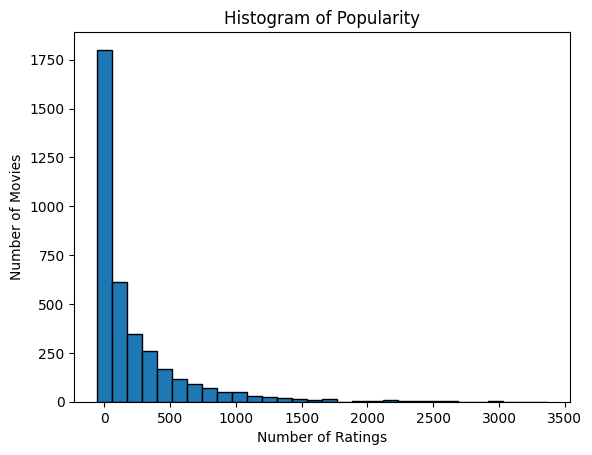

In [23]:
plt.hist(movie_popularity['rating_count'], bins=30, edgecolor='black', align='left')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.title('Histogram of Popularity')
plt.show()

**Exercise**: Plot the histogram of user activity (x-axis: # of given ratings, y-axis: # of users with the given # of ratings). Include the plot in your report.

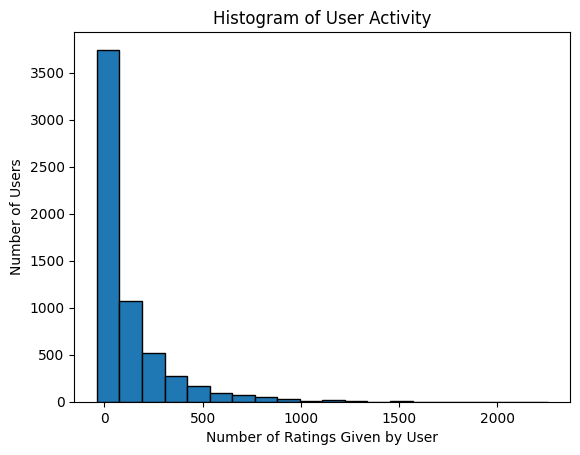

In [24]:
user_activity = all_ratings.groupby('user_id').size()
plt.hist(user_activity, bins=20, edgecolor='black', align='left')
plt.xlabel('Number of Ratings Given by User')
plt.ylabel('Number of Users')
plt.title('Histogram of User Activity')
plt.show()

**Exercise**: Compute the average ratings for every movie and find the top 20 highly rated movies. Include the list of 20 highly rated movies and their ratings in your report. Are these highly rated movies popular?

In [25]:
average_ratings = all_ratings.groupby('item_name')['ratings'].mean()
top_20_highly_rated = average_ratings.sort_values(ascending=False).head(20)
print(top_20_highly_rated)

item_name
Lured (1947)                                                           5.000000
Bittersweet Motel (2000)                                               5.000000
Ulysses (Ulisse) (1954)                                                5.000000
Smashing Time (1967)                                                   5.000000
Baby, The (1973)                                                       5.000000
Gate of Heavenly Peace, The (1995)                                     5.000000
Schlafes Bruder (Brother of Sleep) (1995)                              5.000000
Follow the Bitch (1998)                                                5.000000
One Little Indian (1973)                                               5.000000
Song of Freedom (1936)                                                 5.000000
I Am Cuba (Soy Cuba/Ya Kuba) (1964)                                    4.800000
Lamerica (1994)                                                        4.750000
Apple, The (Sib) (1998)       

---
## Train, Validation, and Test Data

Now we will split the data in _train_, _val_ and _test_ be using a pre-defined function from [scikit-learn](http://scikit-learn.org/stable/)

In [26]:
#Split the data into train, validation and test
from sklearn.model_selection import train_test_split

ratings_trainval, ratings_test = train_test_split(all_ratings, test_size=0.1, random_state=42)

ratings_train, ratings_val = train_test_split(ratings_trainval, test_size=0.1, random_state=42)

In [27]:
user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['ratings']

user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['ratings']

In [28]:
movies_not_train = list(set(all_ratings['item_id']) -set(item_id_train))
movies_not_train_name=set(all_ratings.loc[movies_not_train]['item_name'])
print(movies_not_train_name)

{'Jackie Brown (1997)', 'Bodyguard, The (1992)', 'Celluloid Closet, The (1995)', 'Tomorrow Never Dies (1997)', 'Two if by Sea (1996)', 'Star Wars: Episode IV - A New Hope (1977)', 'Man Who Knew Too Little, The (1997)', 'Alien Nation (1988)', 'Princess Bride, The (1987)', 'Coneheads (1993)', 'Titanic (1997)', 'Final Destination (2000)', 'Star Wars: Episode I - The Phantom Menace (1999)', 'Mighty Ducks, The (1992)', 'Star Trek: The Wrath of Khan (1982)', 'Howards End (1992)', 'Children of the Corn (1984)', 'Rudy (1993)', 'Great Escape, The (1963)', 'Naked Gun: From the Files of Police Squad!, The (1988)', 'Inspector Gadget (1999)', 'In & Out (1997)', 'Simple Plan, A (1998)', 'Home Alone (1990)'}


We see that a few movies are not rated in the train set. For those movies, it is hard to predict their ratings accurately.

---
## Data Load and Batching

Use GPU if available.

In [29]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We define a function to return a triplet of user_num, item_num, rating from the dataframe.

In [30]:
def df_2_tensor(df, device):
    # return a triplet user_num, item_num, rating from the dataframe
    user_num = np.asarray(df['user_num'])
    item_num = np.asarray(df['item_num'])
    rating = np.asarray(df['ratings'])
    return torch.from_numpy(user_num).to(device), torch.from_numpy(item_num).to(device), torch.from_numpy(rating).to(device)

Below, we construct 3 tensors containing the `user_num`, `item_num` and `rating` for the training set. All tensors have the same shape so that `train_user_num[i]` watched `train_item_num[i]` and gave a rating of `train_rating[i]`.

In [31]:
train_user_num, train_item_num, train_rating = df_2_tensor(ratings_train,device)

In [32]:
train_user_num

tensor([5567, 2485, 1009,  ..., 1344, 2365, 2714], device='cuda:0')

In [33]:
len(train_user_num), len(train_item_num), len(train_rating)

(810169, 810169, 810169)

We now do the same thing for the validation and test sets.

In [34]:
val_user_num, val_item_num, val_rating = df_2_tensor(ratings_val,device)
test_user_num, test_item_num, test_rating = df_2_tensor(ratings_test,device)

Now you need to construct a dataset and a dataloader. For this, you can define a first function taking as arguments the tensors defined above and returning a list (Hint: you may use the [zip function](https://www.w3schools.com/python/ref_func_zip.asp)); then a second function taking as argument a dataset, the batchsize and a boolean for the shuffling.

**Exercise**: Filling in the missing code below to construct dataset and dataloader.

In [35]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

def tensor_2_dataset(user, item, rating):
    dataset = TensorDataset(user, item, rating)
    return dataset

def make_dataloader(dataset, bs, shuffle):
    dataloader = DataLoader(dataset, batch_size=bs, shuffle=shuffle)
    return dataloader

In [36]:
train_dataset = tensor_2_dataset(train_user_num,train_item_num, train_rating)
val_dataset = tensor_2_dataset(val_user_num,val_item_num,val_rating)
test_dataset = tensor_2_dataset(test_user_num, test_item_num, test_rating)

In [37]:
train_dataset[0]

(tensor(5567, device='cuda:0'),
 tensor(1702, device='cuda:0'),
 tensor(5, device='cuda:0'))

Load the train, validation, and test data in batchs of size 1024.

In [38]:
train_dataloader = make_dataloader(train_dataset,1024,True)
val_dataloader = make_dataloader(val_dataset,1024, False)
test_dataloader = make_dataloader(test_dataset,1024,False)

---
## The model



In [39]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

We will use some custom embeddings defined as below.

In [40]:
class ScaledEmbedding(nn.Embedding):
    """
    Embedding layer that initialises its values
    to using a normal variable scaled by the inverse
    of the embedding dimension.
    """
    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.normal_(0, 1.0 / self.embedding_dim)
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0.0)


class ZeroEmbedding(nn.Embedding):
    """
    Used for biases.
    """

    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.zero_()
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0.0)

### Creating Our Own Embedding Module

Now, we define the `Model_dot`(class to represents users and items. It's composed of a 4 `embedding` layers:

- a `(num_users x latent_dim)` embedding layer to represent users,
- a `(num_items x latent_dim)` embedding layer to represent items,
- a `(num_users x 1)` embedding layer to represent user biases, and
- a `(num_items x 1)` embedding layer to represent item biases.







**Exercise**: Fill the missing code to define the embeddings.

In [41]:
class DotModel(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32):
        super(DotModel, self).__init__()

        self.embedding_dim = embedding_dim

        # User and item embeddings using ScaledEmbedding
        self.user_embeddings = ScaledEmbedding(num_users, embedding_dim)
        self.item_embeddings = ScaledEmbedding(num_items, embedding_dim)

        # User and item biases using ZeroEmbedding
        self.user_biases = ZeroEmbedding(num_users, 1)
        self.item_biases = ZeroEmbedding(num_items, 1)

    def forward(self, user_ids, item_ids):
        # Get embeddings and biases for users and items
        user_embedding = self.user_embeddings(user_ids)  # Shape: (batch_size, embedding_dim)
        item_embedding = self.item_embeddings(item_ids)  # Shape: (batch_size, embedding_dim)
        user_bias = self.user_biases(user_ids).squeeze()  # Shape: (batch_size,)
        item_bias = self.item_biases(item_ids).squeeze()  # Shape: (batch_size,)

        # Compute dot product between user and item embeddings
        dot_product = (user_embedding * item_embedding).sum(dim=1)  # Shape: (batch_size,)

        # Add biases to the dot product
        prediction = dot_product + user_bias + item_bias  # Shape: (batch_size,)

        return prediction


In [42]:
net = DotModel(total_user_id,total_item_id).to(device)

In [43]:
net

DotModel(
  (user_embeddings): ScaledEmbedding(6040, 32)
  (item_embeddings): ScaledEmbedding(3706, 32)
  (user_biases): ZeroEmbedding(6040, 1)
  (item_biases): ZeroEmbedding(3706, 1)
)

Now we check your network by taking  a batch from train loader.

In [44]:
batch_user, batch_item, batch_rating = next(iter(train_dataloader))
batch_user, batch_item, batch_rating = batch_user.to(device), batch_item.to(device), batch_rating.to(device)

In [45]:
predictions = net(batch_user, batch_item)
predictions.shape

torch.Size([1024])

We will use MSE loss defined below:

In [46]:
def regression_loss(predicted_ratings, observed_ratings):
    return ((observed_ratings - predicted_ratings) ** 2).mean()

In [47]:
loss=regression_loss(predictions,batch_rating)

In [48]:
loss

tensor(13.6928, device='cuda:0', grad_fn=<MeanBackward0>)

## Train and test the model

Now we define `FactorizationModel` class  that allows us to train and evaluate the explicit factorization models.


- The `fit` function should take as argument a dataloader for the training and a dataloader for the validation. At the end of each epoch, you run the test method on the validation set. Then you print both the loss on the training set and on the validation set to see if you are overfitting.

- Weight decay, or *L2 regularization*, consists in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.

**Exercise**: Filling in the missing code below to complete the training pass and validation pass.

In [49]:
class FactorizationModel(object):

    def __init__(self, embedding_dim=32, n_iter=20, l2=0.0,
                 learning_rate=1e-2, device=device, net=None, num_users=None,
                 num_items=None,random_state=None):

        self._embedding_dim = embedding_dim
        self._n_iter = n_iter
        self._learning_rate = learning_rate
        self._l2 = l2
        self._device = device
        self._num_users = num_users
        self._num_items = num_items
        self._net = net
        self._optimizer = None
        self._loss_func = None
        self._random_state = random_state or np.random.RandomState()


    def _initialize(self):
        if self._net is None:
            self._net = DotModel(self._num_users, self._num_items, self._embedding_dim).to(self._device)

        self._optimizer = optim.Adam(
                self._net.parameters(),
                lr=self._learning_rate,
                weight_decay=self._l2
            )

        self._loss_func = regression_loss

    @property
    def _initialized(self):
        return self._optimizer is not None


    def fit(self, dataloader, val_dataloader, verbose=True):
        if not self._initialized:
            self._initialize()

        valid_loss_min = np.Inf # track change in validation loss
        train_losses, valid_losses, valid_maes =[], [], [] # track train losses, valid loss, and valid maes over epoches

        for epoch_num in range(self._n_iter):
            tot_train_loss = 0.0
            ###################
            # train the model #
            ###################
            #TODO: trainining loop:
            # your code
            for user_ids, item_ids, ratings in dataloader:
                user_ids, item_ids, ratings = user_ids.to(self._device), item_ids.to(self._device), ratings.to(self._device)

                self._optimizer.zero_grad()

                predictions = self._net(user_ids, item_ids)

                loss = self._loss_func(predictions, ratings)
                tot_train_loss += loss.item()

                loss.backward()
                self._optimizer.step()

            train_loss = tot_train_loss /len(dataloader)

            # Go to the validation loop
            valid_loss, valid_mae = self.test(val_dataloader)

            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            valid_maes.append(valid_mae)

            if verbose:
                print('Epoch {}: loss_train {}, loss_val {}'.format(epoch_num, train_loss,valid_loss))

            if np.isnan(train_loss) or train_loss == 0.0:
                raise ValueError('Degenerate train loss: {}'.format(train_loss))

            #TODO: Saving model if validation loss has decreased
            # your code
            if valid_loss < valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.4f} --> {valid_loss:.4f}). Saving model...")
                valid_loss_min = valid_loss
                best_model_state = self._net.state_dict()

        self._net.load_state_dict(best_model_state)

        return train_losses, valid_losses, valid_maes

    ######################
    # validate/Test the model #
    ######################
    def test(self,dataloader, verbose = False):
        self._net.eval()
        L1loss = torch.nn.L1Loss()
        tot_test_loss = 0.0
        tot_test_mae = 0.0

        # TODO: validation/testing loop
        # your code here (mae = mean absolute error)
        with torch.no_grad():
            for user_ids, item_ids, ratings in dataloader:

                user_ids, item_ids, ratings = user_ids.to(self._device), item_ids.to(self._device), ratings.to(self._device)

                predictions = self._net(user_ids, item_ids)

                loss = self._loss_func(predictions, ratings)
                tot_test_loss += loss.item()

                mae = L1loss(predictions, ratings)
                tot_test_mae += mae.item()

        test_loss = tot_test_loss / len(dataloader)
        test_mae = tot_test_mae / len(dataloader)
        if verbose:
            print(f"RMSE: {np.sqrt(test_loss)}, MAE: {test_mae}")
        return test_loss, test_mae

In [50]:
#TODO: Construct your model using FactorizationModel
# your code
num_users = all_ratings['user_id'].nunique()
num_items = all_ratings['item_id'].nunique()

print(f"Number of users: {num_users}")
print(f"Number of items: {num_items}")

model = FactorizationModel(
    embedding_dim=32,
    n_iter=20,
    l2=1e-5,
    learning_rate=1e-3,
    device=device,
    num_users=num_users,
    num_items=num_items
)


Number of users: 6040
Number of items: 3706


**Exercise**: Train the model and plot the train losses and valid losses over epoches.
At which epoch, you would stop the training? Include the plot and your answer in the report.

Epoch 0: loss_train 7.541932571265432, loss_val 1.4434995353221893
Validation loss decreased (inf --> 1.4435). Saving model...
Epoch 1: loss_train 1.0603801206958414, loss_val 0.9058768864382397
Validation loss decreased (1.4435 --> 0.9059). Saving model...
Epoch 2: loss_train 0.8609670800241557, loss_val 0.8447794541716576
Validation loss decreased (0.9059 --> 0.8448). Saving model...
Epoch 3: loss_train 0.8205398477689184, loss_val 0.8237962553446944
Validation loss decreased (0.8448 --> 0.8238). Saving model...
Epoch 4: loss_train 0.7995365559302196, loss_val 0.8114298256960782
Validation loss decreased (0.8238 --> 0.8114). Saving model...
Epoch 5: loss_train 0.7858467349650884, loss_val 0.8037107681686227
Validation loss decreased (0.8114 --> 0.8037). Saving model...
Epoch 6: loss_train 0.775410919403187, loss_val 0.7964095168493011
Validation loss decreased (0.8037 --> 0.7964). Saving model...
Epoch 7: loss_train 0.765693788049799, loss_val 0.7917057736353441
Validation loss decre

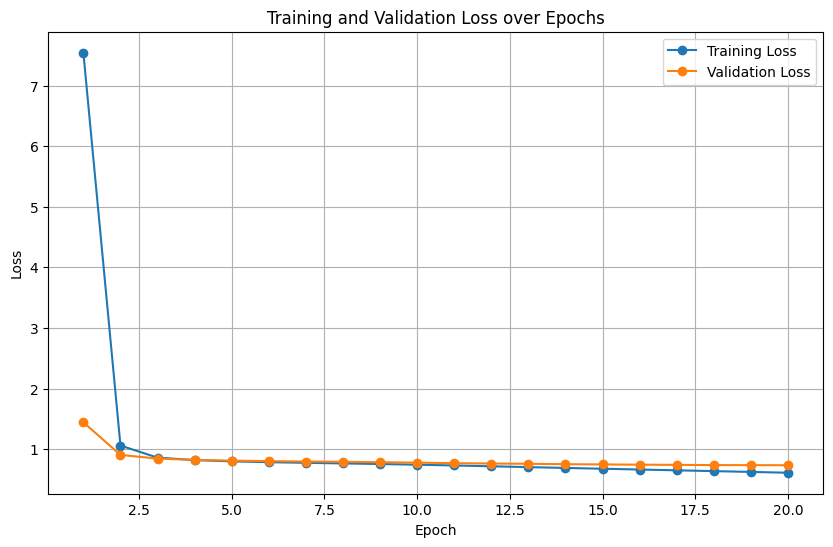

In [51]:
train_losses, valid_losses, valid_maes = model.fit(train_dataloader, val_dataloader, verbose=True)
epochs = range(1, len(train_losses) + 1)  # Epochs (1 to n_iter)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, valid_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

**Exercise**: Now, let's compute the RMSE and mean absolute error on the test data. Include your answers in your report.

In [52]:
test_loss, test_mae = model.test(test_dataloader)
test_rmse = np.sqrt(test_loss)

print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")


Test RMSE: 0.859961625487954
Test MAE: 0.6744652609435879


## Optimize your model and training

**Exercise**: Play with the hyperparameters (embedding_dim, n_iter, learning_rate, L2 regularization, etc) to beat the benchmarks presented in [Surprise](https://github.com/NicolasHug/Surprise). List the hyperparameters and the **RMSE** (square root of the mean sequared error) and MAE on test data in the report. Save the model state to `model_cf.pt` and submit it to Canvas.


In [53]:
from itertools import product
import numpy as np
import torch

# Define the hyperparameter space
embedding_dims = [32, 64]
n_iters = [30,50]
learning_rates = [1e-3, 5e-4]
l2_regs = [1e-5, 1e-6]

# Generate all combinations of hyperparameters
hyperparams = [
    {'embedding_dim': ed, 'n_iter': ni, 'learning_rate': lr, 'l2': l2}
    for ed, ni, lr, l2 in product(embedding_dims, n_iters, learning_rates, l2_regs)
]

best_rmse = np.inf
best_mae = np.inf
best_hyperparams = None

for params in hyperparams:
    print(f"Training with hyperparameters: {params}")
    model = FactorizationModel(
        embedding_dim=params['embedding_dim'],
        n_iter=params['n_iter'],
        learning_rate=params['learning_rate'],
        l2=params['l2'],
        device=device,
        num_users=total_user_id,
        num_items=total_item_id,
    )

    train_losses, valid_losses, valid_maes = model.fit(train_dataloader, val_dataloader, verbose=False)

    test_loss, test_mae = model.test(test_dataloader)
    test_rmse = np.sqrt(test_loss)

    if test_rmse < best_rmse:
        best_rmse = test_rmse
        best_mae = test_mae
        best_hyperparams = params
        torch.save(model._net.state_dict(), "model_cf.pt")

    print(f"RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}")

print(f"Best Hyperparameters: {best_hyperparams}")
print(f"Best RMSE: {best_rmse:.4f}, Best MAE: {best_mae:.4f}")


Training with hyperparameters: {'embedding_dim': 32, 'n_iter': 30, 'learning_rate': 0.001, 'l2': 1e-05}
Validation loss decreased (inf --> 1.4564). Saving model...
Validation loss decreased (1.4564 --> 0.9101). Saving model...
Validation loss decreased (0.9101 --> 0.8584). Saving model...
Validation loss decreased (0.8584 --> 0.8415). Saving model...
Validation loss decreased (0.8415 --> 0.8277). Saving model...
Validation loss decreased (0.8277 --> 0.8129). Saving model...
Validation loss decreased (0.8129 --> 0.8008). Saving model...
Validation loss decreased (0.8008 --> 0.7923). Saving model...
Validation loss decreased (0.7923 --> 0.7844). Saving model...
Validation loss decreased (0.7844 --> 0.7776). Saving model...
Validation loss decreased (0.7776 --> 0.7710). Saving model...
Validation loss decreased (0.7710 --> 0.7658). Saving model...
Validation loss decreased (0.7658 --> 0.7601). Saving model...
Validation loss decreased (0.7601 --> 0.7541). Saving model...
Validation loss d

In [66]:
model = FactorizationModel(
    embedding_dim=64,
    n_iter=30,
    l2=1e-5,
    learning_rate=5e-4,
    device=device,
    num_users=num_users,
    num_items=num_items
)
model._initialize()
model._net.load_state_dict(torch.load("model_cf.pt"))

test_loss, test_mae = model.test(test_dataloader)
test_rmse = np.sqrt(test_loss)

print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")

<ipython-input-66-42267d204547>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model._net.load_state_dict(torch.load("model_cf.pt"))


Test RMSE: 0.8536105412479049
Test MAE: 0.669247357820978


In [99]:
import pandas as pd

data = [
    {"embedding_dim": 32, "n_iter": 30, "learning_rate": 0.001, "l2": 1e-5, "RMSE": 0.8725, "MAE": 0.6821},
    {"embedding_dim": 32, "n_iter": 30, "learning_rate": 0.001, "l2": 1e-6, "RMSE": 0.8929, "MAE": 0.6977},
    {"embedding_dim": 32, "n_iter": 30, "learning_rate": 0.0005, "l2": 1e-5, "RMSE": 0.8656, "MAE": 0.6807},
    {"embedding_dim": 32, "n_iter": 30, "learning_rate": 0.0005, "l2": 1e-6, "RMSE": 0.8614, "MAE": 0.6750},
    {"embedding_dim": 32, "n_iter": 50, "learning_rate": 0.001, "l2": 1e-5, "RMSE": 0.8983, "MAE": 0.7003},
    {"embedding_dim": 32, "n_iter": 50, "learning_rate": 0.001, "l2": 1e-6, "RMSE": 0.9428, "MAE": 0.7312},
    {"embedding_dim": 64, "n_iter": 30, "learning_rate": 0.001, "l2": 1e-5, "RMSE": 0.9055, "MAE": 0.7079},
    {"embedding_dim": 64, "n_iter": 30, "learning_rate": 0.001, "l2": 1e-6, "RMSE": 0.9539, "MAE": 0.7436},
    {"embedding_dim": 64, "n_iter": 30, "learning_rate": 0.0005, "l2": 1e-5, "RMSE": 0.8536, "MAE": 0.6692},
    {"embedding_dim": 64, "n_iter": 30, "learning_rate": 0.0005, "l2": 1e-6, "RMSE": 0.8538, "MAE": 0.6679},
    {"embedding_dim": 64, "n_iter": 50, "learning_rate": 0.001, "l2": 1e-5, "RMSE": 0.9499, "MAE": 0.7400},
    {"embedding_dim": 64, "n_iter": 50, "learning_rate": 0.001, "l2": 1e-6, "RMSE": 1.0375, "MAE": 0.8056},
]
print(f"Best Hyperparameters: {best_hyperparams}")
print(f"Best RMSE: {best_rmse:.4f}, Best MAE: {best_mae:.4f}")
df = pd.DataFrame(data)
df


Best Hyperparameters: {'embedding_dim': 64, 'n_iter': 30, 'learning_rate': 0.0005, 'l2': 1e-05}
Best RMSE: 0.8536, Best MAE: 0.6692


,embedding_dim,n_iter,learning_rate,l2,RMSE,MAE
0,32,30,0.0010,0.000010,0.8725,0.6821
1,32,30,0.0010,0.000001,0.8929,0.6977
2,32,30,0.0005,0.000010,0.8656,0.6807
3,32,30,0.0005,0.000001,0.8614,0.6750
4,32,50,0.0010,0.000010,0.8983,0.7003
5,32,50,0.0010,0.000001,0.9428,0.7312
6,64,30,0.0010,0.000010,0.9055,0.7079
7,64,30,0.0010,0.000001,0.9539,0.7436
8,64,30,0.0005,0.000010,0.8536,0.6692
9,64,30,0.0005,0.000001,0.8538,0.6679


Here is comparison between the best benckmarks in [Surprise](https://github.com/NicolasHug/Surprise) and your model after hyperparameters tunning.

| [Movielens 1M](https://grouplens.org/datasets/movielens/1m)                                                                             |   RMSE |   MAE |
|:----------------------------------------------------------------------------------------------------------------------------------------|-------:|------:|
| [SVD++ (cache_ratings=False)](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp)  |  0.862 | 0.672 |
| [SVD++ (cache_ratings=True)](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp)  |  0.862 | 0.672 |
| **Yours**|  **0.854** | **0.669** |



## Interpreting Biases

Now you need to rank the movies according to their bias. For this, you need to recover the biases of the movies, make a list of the pairs `[name of the movie, its bias]` and then sort this list according to the biases. You can use the method sort of a list.

**Exercise**: What are your top 10 movies with the largest values of movie bias? What do you think about this ranking? Include your answers in your report.

In [67]:
#TODO: retreive the bias of the movies from your optimized model and store it in the numpy array item_bais_np
item_bias_np = model._net.item_biases.weight.data.cpu().numpy()
item_bias_np = item_bias_np.squeeze()

In [68]:
# construct a dictionary that maps item_num to item_name, and vice versa
numitem_2_name = {i:name for name,i in np.asarray(all_ratings[['item_name', 'item_num']])}
name_2_numitem = {name:i for name,i in np.asarray(all_ratings[['item_name', 'item_num']])}

In [69]:
# Construct a list of movie names and the corresponding bias.
list_name_bias = [[name, item_bias_np[name_2_numitem[name]]] for name in list(ratings_train['item_name'].unique())]

In [70]:
#TODO: sort the movie names by biases and output the top 10 movie names with the largest biases.
# your code
movie_bias_values = model._net.item_biases.weight.data.cpu().numpy().squeeze()

id_to_name = {item_id: name for item_id, name in zip(all_ratings['item_num'], all_ratings['item_name'])}

movies_with_bias = [
    [id_to_name.get(i), movie_bias_values[i]]
    for i in range(len(movie_bias_values))
]

movies_with_bias.sort(key=lambda x: x[1], reverse=True)
top_10_movies = movies_with_bias[:10]

print("Top 10 movies with largest biases:")
for rank, (movie, bias) in enumerate(top_10_movies, start=1):
    print(f"{rank}. {movie}: Bias = {bias:.4f}")



Top 10 movies with largest biases:
1. Last Days, The (1998): Bias = 0.7168
2. Sanjuro (1962): Bias = 0.7032
3. Lamerica (1994): Bias = 0.6948
4. Pushing Hands (1992): Bias = 0.6932
5. Live Flesh (1997): Bias = 0.6759
6. Harmonists, The (1997): Bias = 0.6746
7. Man from Laramie, The (1955): Bias = 0.6744
8. Sea Wolves, The (1980): Bias = 0.6733
9. Aparajito (1956): Bias = 0.6733
10. Apple, The (Sib) (1998): Bias = 0.6721


## PCA of movies' embeddings

Now you can also play with the embeddings learned by your algorithm for the movies.

It is not quite so easy to directly interpret the embedding matrices. There are just too many factors for a human to look at. But there is a technique that can pull out the most important underlying *directions* in such a matrix, called *principal component analysis* (PCA). We will not be going into this in detail in this class, because it is not particularly important for you to understand to be a deep learning practitioner. We can visualize the movie embeddings based on two of the strongest PCA components.

**Exercise**: Do you observe anything interesting from the movie embeddings? Include the plot of the movie embeddings and your answer in your report.

In [71]:
from sklearn.decomposition import PCA
from operator import itemgetter

In [72]:
#TODO: retrive your movie embedding vectors and store them as a numpy matrix
item_emb_np = model._net.item_embeddings.weight.data.cpu().numpy()

In [73]:
#Here we perform PCA to extract the 4 principal components
pca = PCA(n_components=4)
latent_fac = pca.fit_transform(item_emb_np)

Next, we plot the embeddings of the top 80 mostly rated movies using the second and third principal components.

In [74]:
# Group by 'item_name' and count ratings
g = all_ratings.groupby('item_name')['ratings'].count()

# Get the top 80 most-rated movies
most_rated_movies = g.sort_values(ascending=False).index.values[:80]

# Map movie names to their numbers (IDs)
most_rated_movies_num = [name_2_numitem[n] for n in most_rated_movies]

print("Top 80 most-rated movie numbers:", most_rated_movies_num[:10])


Top 80 most-rated movie numbers: [2651, 253, 1106, 1120, 466, 1848, 575, 2374, 1178, 579]


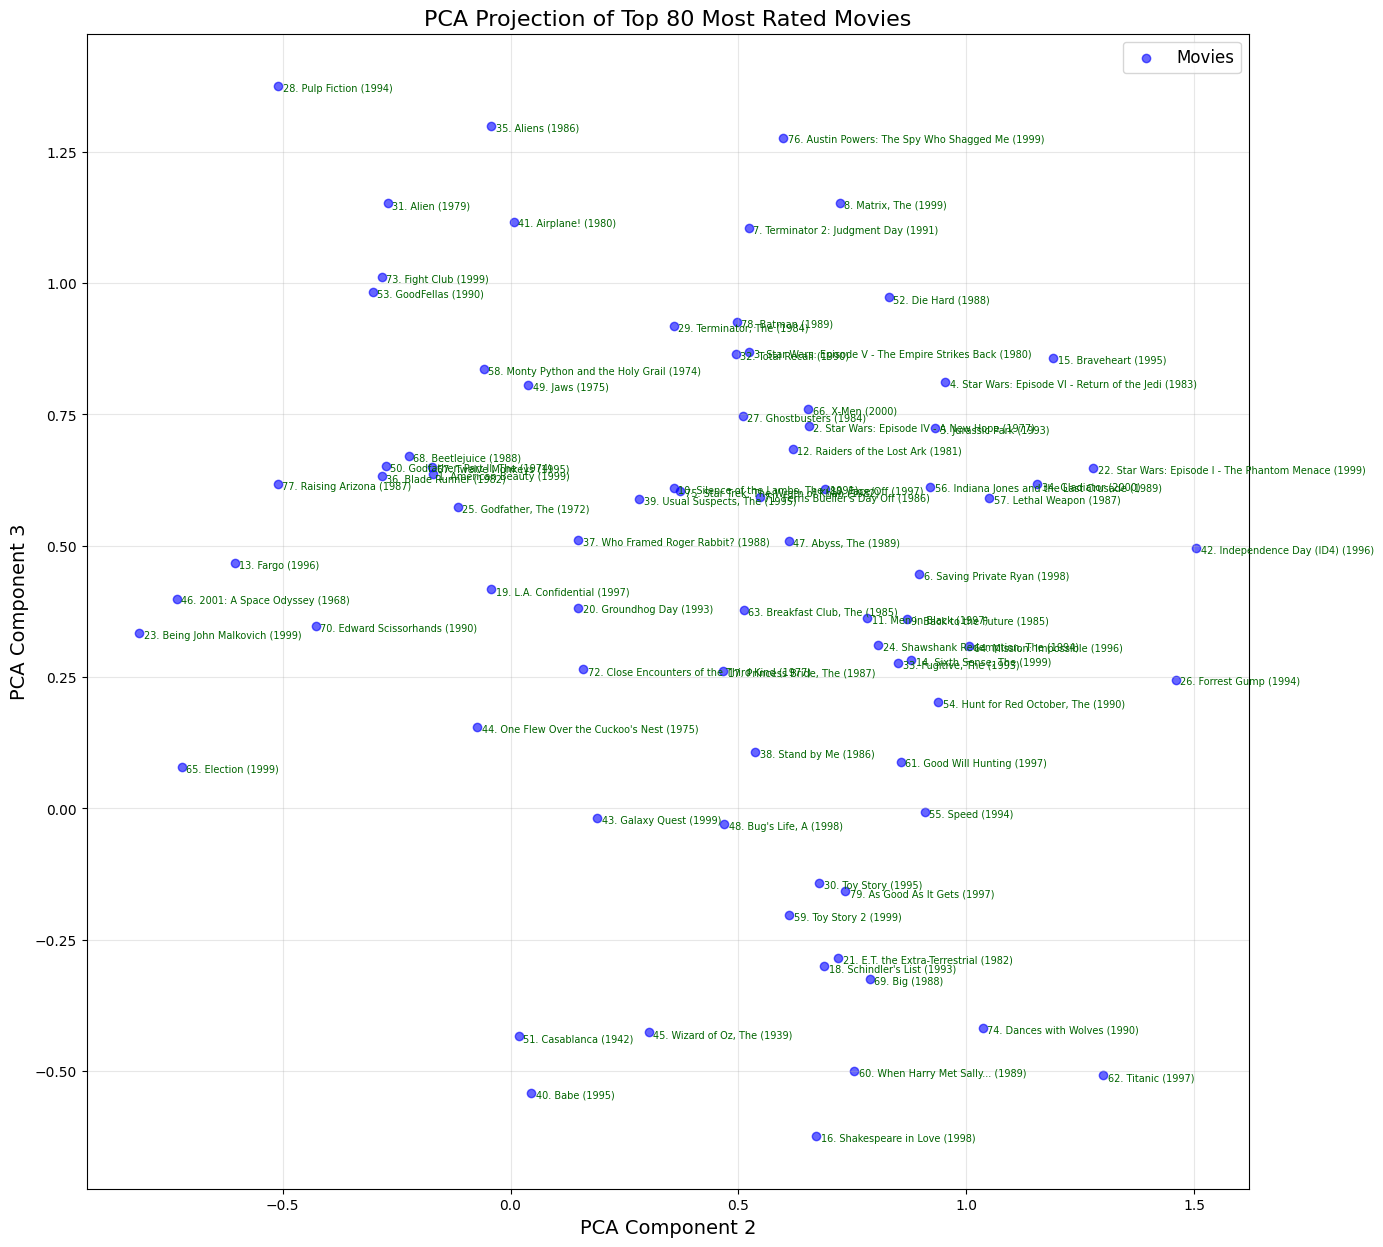

In [75]:
import matplotlib.pyplot as plt

# Assuming the necessary variables are already defined:
# - `most_rated_movies_num`: Indices of the most rated movies.
# - `latent_fac`: Matrix containing latent factors (e.g., PCA components of embeddings).
# - `numitem_to_name`: Mapping from item numbers to movie names.

# Extract the names and PCA components for the top 80 most rated movies
nums = most_rated_movies_num  # Indices of the top 80 most rated movies
txt_movies_names = [numitem_2_name[i] for i in nums]  # Corresponding movie names

# Extract the PCA components (2nd and 3rd elements)
X = latent_fac[nums, 1]
Y = latent_fac[nums, 2]

# Create the scatter plot
plt.figure(figsize=(15, 15))
plt.scatter(X, Y, c='blue', alpha=0.6, label='Movies')

# Annotate points with movie names and their rank
for rank, (name, x, y) in enumerate(zip(txt_movies_names, X, Y), start=1):
    plt.text(x + 0.01, y - 0.01, f"{rank}. {name}", fontsize=7, color='darkgreen')

# Add labels and title for better understanding
plt.title("PCA Projection of Top 80 Most Rated Movies", fontsize=16)
plt.xlabel("PCA Component 2", fontsize=14)
plt.ylabel("PCA Component 3", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Display the plot
plt.show()


## Predict your own ratings

Now that we have succesfully trained a model, let's see how to deal with the situation where we have a new user. How can we make recommendations to new users?

It turns out that we can utilize the learned movie embedding vectors to estimate new users' embedding vector, based on a few ratings from them. You may have noticed that when you sign up for services such as Pandora and Netflix, they tend to ask you a few questions about what movie or music you like; this is how they come up with your initial collaborative filtering recommendations.


- First, give 40 ratings between 1-5 to the movies that your team watched before among the mostly rated movies;

In [76]:
most_rated_movies = all_ratings['item_num'].value_counts().head(100).index

my_ratings = pd.DataFrame({ "item_num": np.random.choice(most_rated_movies, size=40, replace=False),  "rating": np.random.randint(1, 6, size=40) })

my_ratings.head()

,item_num,rating
0,1445,4
1,2511,1
2,527,3
3,699,2
4,1743,1



- Second, compute your own embedding vector `my_emb_np` and `my_emb_bias` by running an ordinary least squares with L_2 regularization based on your ratings and the previously computed movie embedding vectors. In other words, `item_emb_np` is the co-variate and your own 40 ratings are the response.

  Hint: you may use the [ridge regression (linear regression with L2 regularization)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) in the sklearn package.

In [77]:
from sklearn.linear_model import Ridge

item_emb_np = model._net.item_embeddings.weight.data.cpu().numpy()  # Movie embeddings from the trained model
rated_item_ids = my_ratings["item_num"].values  # Movies rated by the new user
rated_item_embeddings = item_emb_np[rated_item_ids]  # Embeddings for the rated movies

user_ratings = my_ratings["rating"].values  # Ratings as the response variable

# Step 4: Use Ridge regression to compute the embedding vector and bias
ridge = Ridge(alpha = 0.001, fit_intercept=True)  # Ridge regression with L2 regularization
ridge.fit(rated_item_embeddings, user_ratings)

# Step 5: Extract the embedding vector and bias
my_emb_np = ridge.coef_  # User embedding vector
my_emb_bias = ridge.intercept_  # User bias

# Output the results
print("New User Embedding Vector (my_emb_np):", my_emb_np)
print("New User Embedding Bias (my_emb_bias):", my_emb_bias)

New User Embedding Vector (my_emb_np): [-1.5984615e+00  1.8567499e+00  4.6488452e-01 -1.7173791e+00
 -1.0393233e+00  2.3432724e-01 -2.2481789e-01  5.1274967e-01
 -1.3254112e+00  6.5566003e-01  5.2425973e-03  1.1942582e+00
  9.3452388e-01 -4.8283906e+00 -3.3431406e+00 -6.6099256e-01
 -7.7658010e-01  2.3333770e-01 -1.1039356e+00  4.6341982e-01
 -2.3447670e-01 -6.7990214e-01 -1.2784818e+00 -1.9010683e+00
 -1.2750750e+00  5.3000993e-01  2.3144693e+00 -2.7648753e-01
  4.4256425e-03  1.0502203e+00 -9.4921315e-01  1.6953953e-01
  2.7706696e-02 -2.0330598e+00  1.8126227e+00 -4.1593668e-01
 -2.7374071e-03  4.9245206e-01 -1.9009188e+00 -2.1857171e+00
  1.1620272e+00 -2.5032642e+00  1.3602729e+00  4.7606128e-01
  3.1256716e+00  4.6746278e-01 -1.5913457e+00 -1.2796494e+00
 -9.0920508e-02 -5.0182265e-01 -5.0408691e-01  1.0795715e+00
 -1.4595358e-02 -1.2633084e+00  4.6595061e-01 -4.7209732e-02
 -9.2277694e-01 -4.1757756e-01 -6.2404603e-01  8.2202524e-01
  6.8890297e-01  8.3091184e-02  5.7004392e-01 

In [78]:
my_emb_np.shape

(64,)

-  Then compute the predicted ratings for all movies using your embedding vectors and biases, together with the movie embedding vectors and biases.

In [79]:
# Then compute the predicted ratings for all movies using your embedding vectors and biases, together with the movie embedding vectors and biases.
pred_ratings = np.dot(item_emb_np, my_emb_np) + my_emb_bias + item_bias_np

- Finally, among all movies that you haven't rated, output the top 10 movies with the highest predicted ratings.

In [80]:
# output the top 10 movies with the highest predicted ratings.
rated_movies = my_ratings["item_num"].values  # Movies already rated by the new user
all_movies = np.arange(item_emb_np.shape[0])  # All movie indices
unrated_movies = np.setdiff1d(all_movies, rated_movies)  # Movies not rated by the user

# Step 4: Filter predicted ratings for unrated movies
unrated_movie_ratings = pred_ratings[unrated_movies]

# Step 5: Get the top 10 movies with the highest predicted ratings
top_10_indices = np.argsort(unrated_movie_ratings)[-10:][::-1]  # Indices of top 10 rated movies
top_10_movie_ids = unrated_movies[top_10_indices]
top_10_ratings = unrated_movie_ratings[top_10_indices]

# Step 6: Map movie IDs to names using all_ratings mapping
top_10_movie_names = [numitem_2_name[item_id] for item_id in top_10_movie_ids]

# Create a DataFrame for display
top_10_movies_df = pd.DataFrame({
    "movie_id": top_10_movie_ids,
    "movie_name": top_10_movie_names,
    "predicted_rating": top_10_ratings
})
top_10_movies_df

,movie_id,movie_name,predicted_rating
0,2210,First Blood (1982),9.235331
1,705,Thinner (1996),8.965622
2,1798,Friday the 13th Part V: A New Beginning (1985),8.927766
3,831,Halloween: The Curse of Michael Myers (1995),8.887348
4,1796,Friday the 13th Part 3: 3D (1982),8.800321
5,1799,Friday the 13th Part VI: Jason Lives (1986),8.721672
6,2219,Rocky V (1990),8.678473
7,2364,Ravenous (1999),8.600521
8,1805,Halloween 4: The Return of Michael Myers (1988),8.597535
9,1803,Halloween II (1981),8.588351


**Question**: How do you feel about the predicted ratings? Do you like these top 10 movies? Include your answer in your report.

---
## Movie valuation

The rating data provided the company like Netflix information about the value of a movie that was not available to movie production studios. The collaborative filting algorithm allows Netflix to accurately value the content in a data-driven manner. For example, if Netflix were offered the opportunity to license *Toy Story (1995)*, it would need to provide Disney an initial quote of the license fee. Traditional methods suggest looking at box office returns of *Toy Story* franchise and projecting the potential value of the film.

In this following, we will explore a novel approach to determine the valuation of a movie based on the predicted ratings. We make the following simplifying assumpitons (Note that these assumptions can be certainly relaxed with more complicated procedures and data):

- **Netflix are focusing on the top 1000 active users and 1000 popular movies (with the most number of observed ratings).** In other words, in the following movie valuation calculation, we just consider the top 1000 activie users and 1000 popular movies, disregarding the rest.

- For each user, the total amount of viewing time is proportional to the number of observed ratings. In other words, more active users spend more time on Netflix;

- For each given user, the viewing time across different movies follow a [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), that is

  $$
    \text{Viewtime of movie $i$} \propto \frac{1}{\text{rank of } i }
  $$
  Here the rank of $i$ is determined by sorting the **predicted rating** of movie $i$ by the user in descending order. In other words, the user spend less time on watching movies with lower ratings.

- Netflix has a fixed total budget of 1 Billion dollars to license the content;

- Netflix estimates the value of a movie based on the expected share of customer viewing time of the movie on its platform:

$$
\text{Value of a movie $i$ } = \frac{\text{View time of movie $i$ of all users}}{\text{Total view time of all users} } \times \text{Total content license budget}
$$


### Compute the value of each movie

In [81]:
# Get indices for top 1000 active users and top 1000 mostly rated movies
top1000_user_num = pd.Series(all_ratings["user_num"].value_counts()[:1000].index, name="user_num")
top1000_item_num = pd.Series(all_ratings["item_num"].value_counts()[:1000].index, name="item_num")
# Construct dataframes for storing predicted ratings
pred_ratings = pd.merge(top1000_user_num, top1000_item_num, how="cross")
cartesian_user_num = torch.from_numpy(np.asarray(pred_ratings["user_num"])).to(device)
cartesian_item_num = torch.from_numpy(np.asarray(pred_ratings["item_num"])).to(device)

In [82]:
pred_ratings.head()

,user_num,item_num
0,4168,2651
1,4168,253
2,4168,1106
3,4168,1120
4,4168,466


In [83]:
# sanity check: # of rows in pred_ratings == # of active users (1000) x # of popular items (1000)
pred_ratings.shape[0] == 1000 * 1000

True

In [84]:
#TODO: use your optimized model to compute the predicted ratings among the top 1000 active users and top 1000 popular movies
pred_ratings["pred_ratings"] = model._net(cartesian_user_num, cartesian_item_num).detach().cpu().numpy()

In [85]:
# Each user's total viewtime is stored in Series user_total_viewtime
user_total_viewtime = all_ratings["user_num"].value_counts()[:1000] / all_ratings["user_num"].value_counts()[:1000].sum()
user_total_viewtime.name = "user_total_viewtime"
user_total_viewtime.index.name = "user_num"
pred_ratings = pd.merge(pred_ratings, user_total_viewtime, left_on="user_num", right_on="user_num", how="left")

In [86]:
pred_ratings.head()

,user_num,item_num,pred_ratings,user_total_viewtime
0,4168,2651,5.581336,0.00449
1,4168,253,4.739365,0.00449
2,4168,1106,4.640034,0.00449
3,4168,1120,3.719947,0.00449
4,4168,466,5.289580,0.00449


In [87]:
# Each user per each movie viewtime: pred_all_ratings["user_item_viewtime"] = ["1/user_rank"] / ["sum(1/user_rank)"] * ["user_total_viewtime"]
# these wordy codes are to reduce RAM consumption otherwise Colab may crush
pred_ratings["1/user_rank"] = 1/pred_ratings.groupby("user_num")["pred_ratings"].rank(method = "min", ascending = False)
sum_inverse_user_rank = pred_ratings.groupby("user_num")["1/user_rank"].sum()
sum_inverse_user_rank.name = "sum(1/user_rank)"
pred_ratings = pd.merge(pred_ratings, sum_inverse_user_rank, left_on="user_num", right_on="user_num", how="left")
pred_ratings["user_item_viewtime"] = pred_ratings["1/user_rank"] / pred_ratings["sum(1/user_rank)"] * pred_ratings["user_total_viewtime"]

In [88]:
pred_ratings

,user_num,item_num,pred_ratings,user_total_viewtime,1/user_rank,sum(1/user_rank),user_item_viewtime
0,4168,2651,5.581336,0.004490,0.166667,7.485471,9.997891e-05
1,4168,253,4.739365,0.004490,0.007042,7.485471,4.224461e-06
2,4168,1106,4.640034,0.004490,0.005650,7.485471,3.389116e-06
3,4168,1120,3.719947,0.004490,0.001757,7.485471,1.054259e-06
4,4168,466,5.289580,0.004490,0.041667,7.485471,2.499473e-05
...,...,...,...,...,...,...,...
999995,1541,3261,3.715906,0.000569,0.002532,7.485471,1.922945e-07
999996,1541,2614,3.924575,0.000569,0.004444,7.485471,3.375836e-07
999997,1541,67,3.467766,0.000569,0.001675,7.485471,1.272300e-07
999998,1541,966,3.614865,0.000569,0.002110,7.485471,1.602454e-07


In [89]:
# sanity check: sum of user_item_viewtime == 1
pred_ratings["user_item_viewtime"].sum()

1.0000000000000004

In [90]:
# compute each movie's value
budget = 1000000000
#TODO: compute and store the values of movies based on pred_ratings
movie_values = pred_ratings.groupby("item_num")["user_item_viewtime"].sum() * budget
movie_values.name = "item_value"

In [91]:
# replace item_num by item_name
movie_values = movie_values.to_frame()
movie_values["item_name"] = [numitem_2_name[item_num] for item_num in movie_values.index]
movie_values = movie_values.set_index("item_name").squeeze(axis=1)

In [92]:
movie_values.head()

,item_value
item_name,
Toy Story (1995),4.540523e+06
Jumanji (1995),1.998671e+05
Grumpier Old Men (1995),1.793220e+05
Heat (1995),4.570332e+05
Sabrina (1995),2.098680e+05


In [93]:
# sanity check: sum of movie values == budget
print(movie_values.sum() == budget)
print(movie_values.sum())

True
1000000000.0


### Output the top valued movies

**Question**: Include your answer in the report.

- What is your estimated value of *Toy Story (1995)*?

- What are the top 10 mostly valued movies?


In [94]:
movie_values

,item_value
item_name,
Toy Story (1995),4.540523e+06
Jumanji (1995),1.998671e+05
Grumpier Old Men (1995),1.793220e+05
Heat (1995),4.570332e+05
Sabrina (1995),2.098680e+05
...,...
Best in Show (2000),9.904996e+05
Remember the Titans (2000),2.622022e+06
Fantastic Voyage (1966),3.103562e+05


In [95]:
# your code
# Step 1: Find the value of "Toy Story (1995)"
toy_story_value = movie_values.loc["Toy Story (1995)"]
print(f"Estimated value of 'Toy Story (1995)': ${toy_story_value:,.2f}")

# Step 2: Find the top 10 highest valued movies
top_10_movies = movie_values.sort_values(ascending=False).head(10)
print("Top 10 highest valued movies:")
print(top_10_movies)



Estimated value of 'Toy Story (1995)': $4,540,522.65
Top 10 highest valued movies:
item_name
Godfather, The (1972)                                                          3.374008e+07
Raiders of the Lost Ark (1981)                                                 2.254294e+07
Star Wars: Episode IV - A New Hope (1977)                                      2.083304e+07
American Beauty (1999)                                                         1.800831e+07
Pulp Fiction (1994)                                                            1.580941e+07
Shawshank Redemption, The (1994)                                               1.490603e+07
Schindler's List (1993)                                                        1.306673e+07
Casablanca (1942)                                                              1.033846e+07
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)    1.014664e+07
Sixth Sense, The (1999)                                                        


### Compare the output with the mostly rated movies. Identify the discrepancies.

**Question**: Include your answers in your report.

- What are the movies that are top 30 rated but not in top 30 valued?
- What do you think about this approach of movie valuation? How does it compare with the approach based on the popularity of the movies?




In [96]:
# your code
# Step 1: Find the top 30 rated movies (by total number of ratings)
top_30_rated_movies = (
    all_ratings["item_num"]
    .value_counts()
    .head(30)
    .index.map(numitem_2_name)
)

# Step 2: Find the top 30 valued movies (already sorted by value)
top_30_valued_movies = movie_values.sort_values(ascending=False).head(30).index

# Step 3: Identify movies in top 30 rated but not in top 30 valued
rated_not_valued = list(set(top_30_rated_movies) - set(top_30_valued_movies))
print("Movies in top 30 rated but not in top 30 valued:")
for i in range(len(rated_not_valued)):
    print(f"{i+1}. {rated_not_valued[i]}")

Movies in top 30 rated but not in top 30 valued:
1. Back to the Future (1985)
2. Men in Black (1997)
3. Shakespeare in Love (1998)
4. Ghostbusters (1984)
5. Star Wars: Episode I - The Phantom Menace (1999)
6. Toy Story (1995)
7. E.T. the Extra-Terrestrial (1982)
8. Groundhog Day (1993)
9. Jurassic Park (1993)
10. Terminator, The (1984)
11. Star Wars: Episode VI - Return of the Jedi (1983)
12. L.A. Confidential (1997)
13. Terminator 2: Judgment Day (1991)
